In [ ]:
!pip install matplotlib

In [ ]:
!pip install tensorflow

# Загружаю датасет в зип-архиве, распаковываю его в текущую директорию.

In [ ]:
import gdown
import zipfile
import os

def download_dataset(url='https://drive.google.com/uc?id=1OUA5iW0lOOcnlrCYMDImotpGI8sbysDA', output='file.zip'):
    """Загрузка датасета."""
    try:
        gdown.download(url, output, quiet=False)
        print("Файл успешно загружен.")
    except Exception as e:
        print(f"Ошибка при скачивании файла: {e}")
        exit(1)

def extract_dataset(output='file.zip'):
    """Распаковка архива с датасетом."""
    try:
        with zipfile.ZipFile(output, 'r') as zip_ref:
            zip_ref.extractall()  # Распаковка в текущую директорию
        print("Датасет успешно распакован.")
    except zipfile.BadZipFile:
        print("Ошибка: файл не является корректным ZIP-архивом.")
    except Exception as e:
        print(f"Ошибка при распаковке архива: {e}")
        exit(1)
        # Показать содержимое распакованной папки

if __name__ == "__main__":
    download_dataset()
    extract_dataset()

Downloading...
From (original): https://drive.google.com/uc?id=1OUA5iW0lOOcnlrCYMDImotpGI8sbysDA
From (redirected): https://drive.google.com/uc?id=1OUA5iW0lOOcnlrCYMDImotpGI8sbysDA&confirm=t&uuid=6f730db0-1293-4ece-8a82-0eceb639a3ce
To: /content/file.zip
100%|██████████| 2.37G/2.37G [00:50<00:00, 46.9MB/s]


Файл успешно загружен.
Датасет успешно распакован.


# Определяю количество классов и цветовую палитру.

In [ ]:
import numpy as np
import os
from PIL import Image

def count_classes_in_dataset(root_dir, mask_subdir='labels'):
    unique_classes = set()
    mask_path = os.path.join(root_dir, mask_subdir)

    # Проход по всем маскам в указанной директории
    for mask_file in os.listdir(mask_path):
        if mask_file.endswith('.png'):  # Зависит от формата ваших масок
            mask = Image.open(os.path.join(mask_path, mask_file))
            mask_array = np.array(mask)
            unique_classes.update(np.unique(mask_array))

    return len(unique_classes), unique_classes

root_dir = '/content/datasett/train/' # Ваши настройки пути
num_classes, unique_classes = count_classes_in_dataset(root_dir)

print(f'Количество уникальных классов в датасете: {num_classes}')
print(f'Уникальные классы: {unique_classes}')


Количество уникальных классов в датасете: 11
Уникальные классы: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


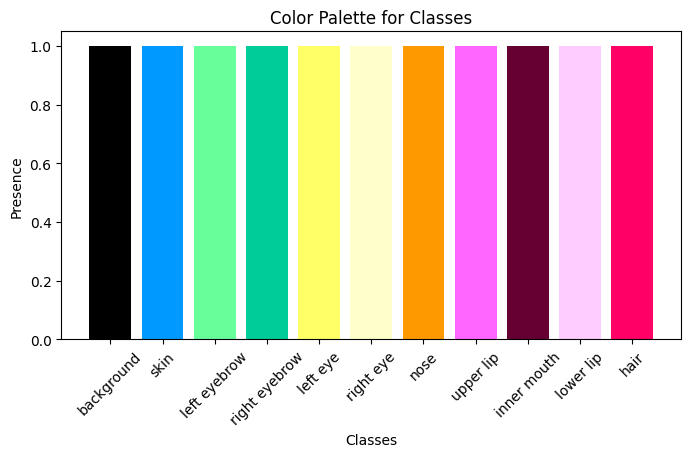

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Соответствие меток и названий классов
class_names = {
    0: "background",
    1: "skin",
    2: "left eyebrow",
    3: "right eyebrow",
    4: "left eye",
    5: "right eye",
    6: "nose",
    7: "upper lip",
    8: "inner mouth",
    9: "lower lip",
    10: "hair"
}

# Соответствие меток и цветов
class_colors = {
    0: [0, 0, 0],            # background
    1: [0, 153, 255],        # skin
    2: [102, 255, 153],      # left eyebrow
    3: [0, 204, 153],        # right eyebrow
    4: [255, 255, 102],      # left eye
    5: [255, 255, 204],      # right eye
    6: [255, 153, 0],        # nose
    7: [255, 102, 255],      # upper lip
    8: [102, 0, 51],         # inner mouth
    9: [255, 204, 255],      # lower lip
    10: [255, 0, 102]        # hair
}

# Функция для визуализации цветовой палитры с названиями классов
def visualize_palette(class_names, class_colors):
    num_classes = len(class_names)
    colors = np.array([class_colors[i] for i in range(num_classes)])

    plt.figure(figsize=(8, 4))

    # Создаем столбчатую диаграмму для отображения цветов
    plt.bar(range(num_classes), [1] * num_classes, color=colors / 255.0)

    plt.xticks(range(num_classes), [class_names[i] for i in range(num_classes)], rotation=45)
    plt.title('Color Palette for Classes')
    plt.xlabel('Classes')
    plt.ylabel('Presence')

    plt.show()

# Визуализируем цветовую палитру с названиями классов
visualize_palette(class_names, class_colors)


# Проверяю, правильно ли видит мои данные коллаб. Определяю 11 классов.


In [ ]:
%%writefile dataset_unet.py

import numpy as np
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array


class FaceSegmentationDataset(Sequence):
    def __init__(self, root_dir, img_size=(128, 128), split='train', batch_size=32, **kwargs):
        super().__init__(**kwargs)
        self.root_dir = root_dir
        self.img_size = img_size
        self.split = split
        self.batch_size = batch_size

        # Проверка наличия необходимых директорий
        self.images_dir = os.path.join(self.root_dir, self.split, 'images')
        self.labels_dir = os.path.join(self.root_dir, self.split, 'labels')

        if not os.path.exists(self.images_dir):
            raise FileNotFoundError(f"Не найдена директория с изображениями: {self.images_dir}")

        if not os.path.exists(self.labels_dir):
            raise FileNotFoundError(f"Не найдена директория с масками: {self.labels_dir}")

        self.image_filenames, self.label_filenames = self.load_data()

    def load_data(self):
        images = sorted(os.listdir(self.images_dir))
        labels = sorted(os.listdir(self.labels_dir))

        if len(images) != len(labels):
            raise ValueError("Количество изображений и масок не совпадает.")

        return images, labels

    def encode_labels(self, label_array):
        num_classes = 11
        class_mask = np.zeros((label_array.shape[0], label_array.shape[1]), dtype=int)

        for cls in range(num_classes):
            class_mask[label_array[..., 0] == cls] = cls

        return class_mask

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.image_filenames[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_labels = self.label_filenames[idx * self.batch_size: (idx + 1) * self.batch_size]

        images = np.zeros((self.batch_size, *self.img_size, 3), dtype=np.float32)
        masks = np.zeros((self.batch_size, *self.img_size), dtype=np.int32)

        for i, (img_file, label_file) in enumerate(zip(batch_images, batch_labels)):
            img_path = os.path.join(self.images_dir, img_file)
            img = load_img(img_path, target_size=self.img_size)
            images[i] = img_to_array(img) / 255.0

            label_path = os.path.join(self.labels_dir, label_file)
            label = load_img(label_path, target_size=self.img_size, color_mode='grayscale')
            masks[i] = self.encode_labels(img_to_array(label))

        return images, masks


Writing dataset_unet.py


## Проверяю насколько правильно загружаются данные


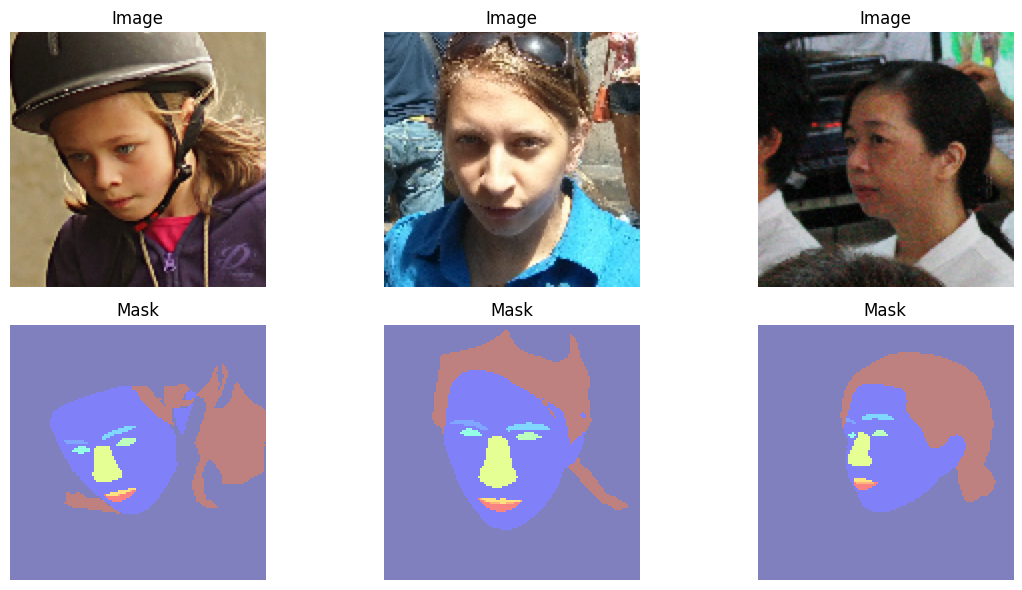

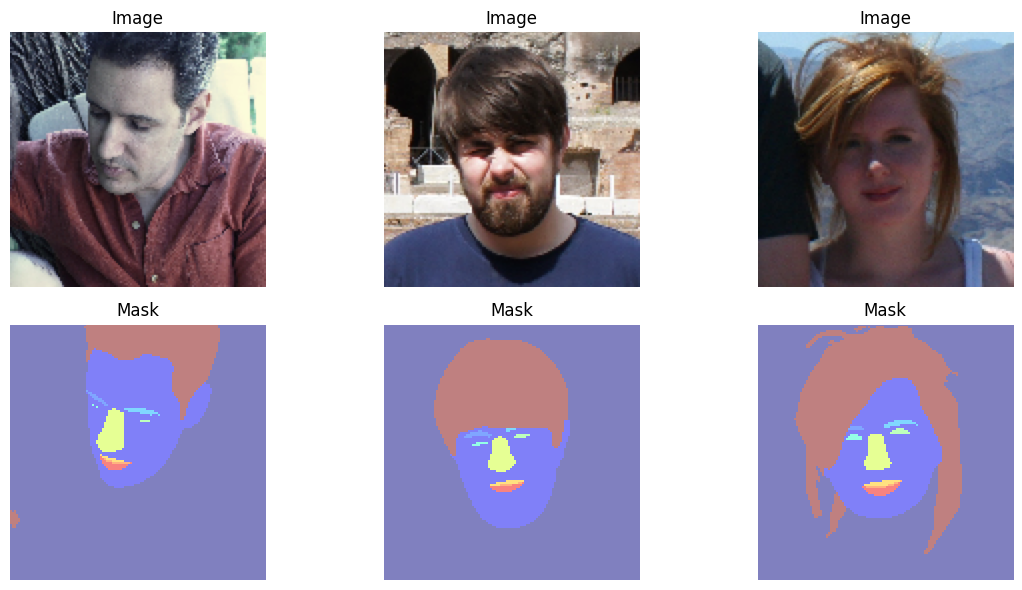

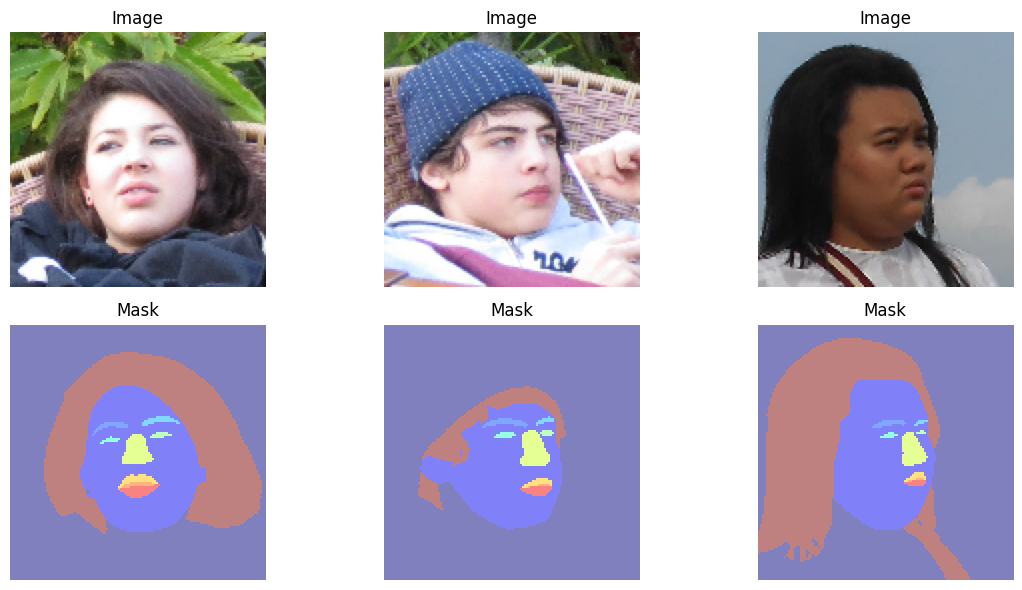

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from dataset_unet import FaceSegmentationDataset

# ---------- Параметры ----------
ROOT_DIR = '/content/datasett'  # Путь до набора данных
IMG_SIZE = (128, 128)                 # Размеры изображений
BATCH_SIZE = 32                        # Размер батча
SPLIT = 'train'                        # Определяет, загружается ли обучающий или тестовый набор

# ---------- Инициализация набора данных ----------
dataset = FaceSegmentationDataset(root_dir=ROOT_DIR, img_size=IMG_SIZE, split=SPLIT, batch_size=BATCH_SIZE)

# ---------- Получаем примеры данных ----------
for i in range(3):  # Получаем 3 батча данных
    images, masks = dataset[i]  # Используйте dataset[i] для получения батча

    plt.figure(figsize=(12, 6))

    for j in range(min(3, len(images))):
        plt.subplot(2, 3, j + 1)
        plt.imshow(images[j])
        plt.title('Image')
        plt.axis('off')

    for j in range(min(3, len(masks))):
        plt.subplot(2, 3, j + 4)
        plt.imshow(masks[j], cmap='jet', alpha=0.5)
        plt.title('Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#Удостоверилась, что все данные определяет верно. Теперь (ниже) создаю классическую unet модель со слоями (Dropout, BatchNormalization).



In [ ]:
%%writefile sample_model.py

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def unet_model(input_shape, num_classes, dropout_rate=0.4):
    inputs = layers.Input(shape=input_shape)

    # Encoder (Сжатие)
    c1 = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)  # Добавлена Batch Normalization
    c1 = layers.Activation('relu')(c1)
    c1 = layers.Conv2D(32, (3, 3), padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)  # Добавлена Batch Normalization
    c1 = layers.Activation('relu')(c1)
    c1 = layers.Dropout(dropout_rate)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # Уровень 2
    c2 = layers.Conv2D(64, (3, 3), padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)  # Добавлена Batch Normalization
    c2 = layers.Activation('relu')(c2)
    c2 = layers.Conv2D(64, (3, 3), padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)  # Добавлена Batch Normalization
    c2 = layers.Activation('relu')(c2)
    c2 = layers.Dropout(dropout_rate)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Уровень 3
    c3 = layers.Conv2D(128, (3, 3), padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)  # Добавлена Batch Normalization
    c3 = layers.Activation('relu')(c3)
    c3 = layers.Conv2D(128, (3, 3), padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)  # Добавлена Batch Normalization
    c3 = layers.Activation('relu')(c3)
    c3 = layers.Dropout(dropout_rate)(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Уровень 4
    c4 = layers.Conv2D(256, (3, 3), padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)  # Добавлена Batch Normalization
    c4 = layers.Activation('relu')(c4)
    c4 = layers.Conv2D(256, (3, 3), padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)  # Добавлена Batch Normalization
    c4 = layers.Activation('relu')(c4)
    c4 = layers.Dropout(dropout_rate)(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck (бутылочное горлышко)
    c5 = layers.Conv2D(512, (3, 3), padding='same')(p4)
    c5 = layers.BatchNormalization()(c5)  # Добавлена Batch Normalization
    c5 = layers.Activation('relu')(c5)
    c5 = layers.Conv2D(512, (3, 3), padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)  # Добавлена Batch Normalization
    c5 = layers.Activation('relu')(c5)
    c5 = layers.Dropout(dropout_rate)(c5)

    # Декодирование
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)  # Добавлена Batch Normalization
    c6 = layers.Activation('relu')(c6)
    c6 = layers.Conv2D(256, (3, 3), padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)  # Добавлена Batch Normalization
    c6 = layers.Activation('relu')(c6)
    c6 = layers.Dropout(dropout_rate)(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)  # Добавлена Batch Normalization
    c7 = layers.Activation('relu')(c7)
    c7 = layers.Conv2D(128, (3, 3), padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)  # Добавлена Batch Normalization
    c7 = layers.Activation('relu')(c7)
    c7 = layers.Dropout(dropout_rate)(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)  # Добавлена Batch Normalization
    c8 = layers.Activation('relu')(c8)
    c8 = layers.Conv2D(64, (3, 3), padding='same')(c8)
    c8 = layers.BatchNormalization()(c8)  # Добавлена Batch Normalization
    c8 = layers.Activation('relu')(c8)
    c8 = layers.Dropout(dropout_rate)(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3, 3), padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)  # Добавлена Batch Normalization
    c9 = layers.Activation('relu')(c9)
    c9 = layers.Conv2D(32, (3, 3), padding='same')(c9)
    c9 = layers.BatchNormalization()(c9)  # Добавлена Batch Normalization
    c9 = layers.Activation('relu')(c9)
    c9 = layers.Dropout(dropout_rate)(c9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# Параметры модели
input_shape = (128, 128, 3)
num_classes = 11

# Создание и компиляция модели
model = unet_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Writing sample_model.py


# Начинаю обучение первой модели.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 32)   │              0 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 64)     │              0 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 64)     │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)       

 Total params: 7,772,203 (29.65 MB)

 Trainable params: 7,766,315 (29.63 MB)

 Non-trainable params: 5,888 (23.00 KB)

Train dataset size: 567
Validation dataset size: 62
Epoch 1/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 193s 260ms/step - accuracy: 0.7499 - loss: 0.9219 - val_accuracy: 0.7981 - val_loss: 0.5921
Epoch 2/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 147s 258ms/step - accuracy: 0.8947 - loss: 0.3131 - val_accuracy: 0.8759 - val_loss: 0.3326
Epoch 3/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 204s 261ms/step - accuracy: 0.9257 - loss: 0.2159 - val_accuracy: 0.9143 - val_loss: 0.2412
Epoch 4/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 141s 246ms/step - accuracy: 0.9380 - loss: 0.1779 - val_accuracy: 0.8992 - val_loss: 0.2808
Epoch 5/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 139s 241ms/step - accuracy: 0.9457 - loss: 0.1526 - val_accuracy: 0.9303 - val_loss: 0.1950
Epoch 6/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 137s 241ms/step - accuracy: 0.9500 - loss: 0.1390 - val_accuracy: 0.9186 - val_loss: 0.2105
Epoch 7/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 141s 239ms/step - accuracy: 0.9539 - loss: 0.1269 - val_accuracy: 0.9340 - val_loss: 0.1808
Epoch 8/100
567/5

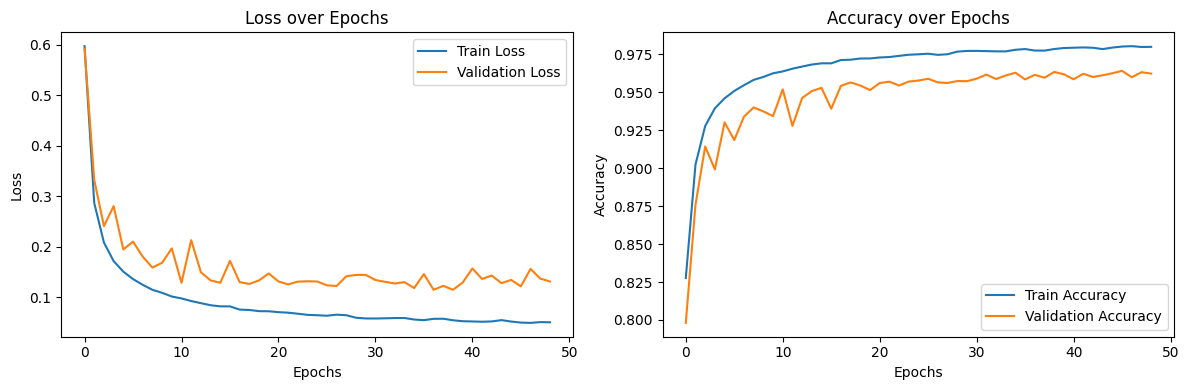

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping  # Импортируем EarlyStopping
from sample_model import unet_model
from dataset_unet import FaceSegmentationDataset
import tensorflow as tf
from keras import backend as K

# Определение параметров
def train_model(root_dir='datasett', img_size=(128, 128), batch_size=32, epochs=100, learning_rate=0.001):
    """Обучение модели U-Net."""
    train_dataset = FaceSegmentationDataset(root_dir, img_size=img_size, split='train', batch_size=batch_size)
    val_dataset = FaceSegmentationDataset(root_dir, img_size=img_size, split='val', batch_size=batch_size)

    print(f'Train dataset size: {len(train_dataset)}')
    print(f'Validation dataset size: {len(val_dataset)}')

    model = unet_model(input_shape=(128, 128, 3), num_classes=11)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping]
    )

    val_loss, val_accuracy = model.evaluate(val_dataset)
    print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')


# Сохранение модели
    model.save('unet_face_segmentation_3_model.keras')

    return history
# Отображение графиков потерь и точности
def plot_history(history):
    """Вывод графиков потерь и точности."""
    plt.figure(figsize=(12, 4))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    history = train_model()
    plot_history(history)

Общая производительность модели

Точная оценка: Модель показывает высокую точность как на обучающем (accuracy: ~97.71% на последней эпохе), так и на валидационном наборе (accuracy: ~96.11%).

Потери: Значение функции потерь сокращается с каждой эпохой как для обучающего (loss: ~0.0592), так и для валидационного наборов (val_loss: ~0.1102). Это говорит о том, что модель последовательно улучшает свои предсказания.

Эффективность обучения

Модель быстро достигает низких значений потерь и высокой точности, что подтверждается тем, что даже к 10-й эпохе достигли значительных показателей (accuracy: ~96.33% и val_accuracy: ~95.30%).

Валидационные метрики: Присутствует хорошая корреляция между тренировочной и валидационной точностью, что указывает на отсутствие переобучения на ранних этапах. В конце процесса видно, что значение val_accuracy остаётся выше 96%.

Анализ проблем

Переобучение: Несмотря на высокие показатели, необходимо следить за потенциалом переобучения. В некоторых эпохах валидационная точность немного колебалась (например, между 4-й и 5-й эпохами), что может сигнализировать о том, что модель иногда не справляется с валидационными данными так же хорошо, как с тренировочными.

Дальнейшая оптимизация: Может быть полезным продолжить обучение на дополнительных эпохах или настроить гиперпараметры (learning rate, dropout, batchsize).

# Проведу еще один эксперимент

Train dataset size: 1135
Validation dataset size: 125
Epoch 1/100
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 179s 125ms/step - accuracy: 0.7016 - loss: 1.0090 - val_accuracy: 0.8313 - val_loss: 0.4476
Epoch 2/100
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 176s 124ms/step - accuracy: 0.8837 - loss: 0.3293 - val_accuracy: 0.8928 - val_loss: 0.2824
Epoch 3/100
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 139s 122ms/step - accuracy: 0.9202 - loss: 0.2240 - val_accuracy: 0.8979 - val_loss: 0.2706
Epoch 4/100
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 141s 124ms/step - accuracy: 0.9365 - loss: 0.1773 - val_accuracy: 0.9265 - val_loss: 0.1915
Epoch 5/100
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 141s 123ms/step - accuracy: 0.9449 - loss: 0.1524 - val_accuracy: 0.9394 - val_loss: 0.1582
Epoch 6/100
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 141s 123ms/step - accuracy: 0.9510 - loss: 0.1340 - val_accuracy: 0.9274 - val_loss: 0.1960
Epoch 7/100
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 140s 123ms/step - accuracy: 0.9545 - loss: 0.1241 - val_accuracy: 0.9446 - val_loss: 0.1467
E

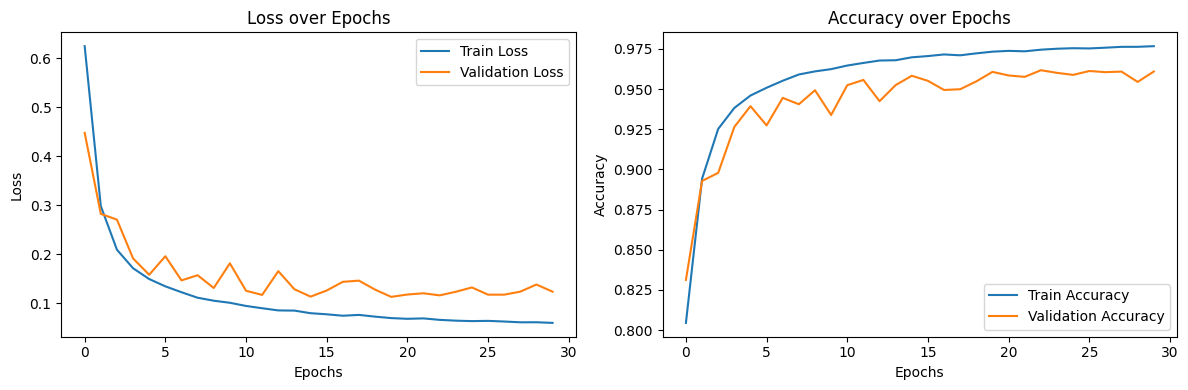

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping  # Импортируем EarlyStopping
from sample_model import unet_model
from dataset_unet import FaceSegmentationDataset
import tensorflow as tf
from keras import backend as K

# Определение параметров
def train_model(root_dir='datasett', img_size=(128, 128), batch_size=16, epochs=100, learning_rate=0.001):
    """Обучение модели U-Net."""
    train_dataset = FaceSegmentationDataset(root_dir, img_size=img_size, split='train', batch_size=batch_size)
    val_dataset = FaceSegmentationDataset(root_dir, img_size=img_size, split='val', batch_size=batch_size)

    print(f'Train dataset size: {len(train_dataset)}')
    print(f'Validation dataset size: {len(val_dataset)}')

    model = unet_model(input_shape=(128, 128, 3), num_classes=11)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping]
    )

    val_loss, val_accuracy = model.evaluate(val_dataset)
    print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')


# Сохранение модели
    model.save('unet_face_segmentation_0_model.keras')

    return history
# Отображение графиков потерь и точности
def plot_history(history):
    """Вывод графиков потерь и точности."""
    plt.figure(figsize=(12, 4))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    history = train_model()
    plot_history(history)

Общая производительность модели

Высокая точность: Модель достигла точности около 97.78% на обучающем наборе и 96.26% на валидационном, что указывает на отличную способность модели к обобщению.

Снижение потерь: Функция потерь уменьшается с каждой эпохой, начиная с 0.8217 на первой эпохе и достигая 0.0570 к 33-й эпохе для тренировочного набора. На валидационном наборе losses также постепенно уменьшаются, достигая 0.1018.

Эффективность обучения

Модель быстро достигает низкого значения потерь и высокой точности. Даже на 2-й эпохе точность на обучающем наборе уже составляет ~90.32%, что говорит о хорошо подобранной модели и структуре нейронной сети.

Возможные проблемы

Потенциальное переобучение: Хотя модель показывает хорошие результаты как на обучающем, так и на валидационном наборах, важно следить за возможным переобучением. В последующих эпохах стоит обратить внимание на колебания валидируемых метрик (например, незначительные снижения точности в некоторых эпохах).

Следует продолжать следить за валидационными метриками для предотвращения потенциального переобучения модели и оптимизации гиперпараметров.

# Проведу следующий эксперимент с изменением размера скорости обучения.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 32)   │              0 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 64)     │              0 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 64)     │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)       

 Total params: 7,772,203 (29.65 MB)

 Trainable params: 7,766,315 (29.63 MB)

 Non-trainable params: 5,888 (23.00 KB)

Train dataset size: 757
Validation dataset size: 83
Epoch 1/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 110s 103ms/step - accuracy: 0.5099 - loss: 1.7220 - val_accuracy: 0.8076 - val_loss: 0.8411
Epoch 2/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 75s 99ms/step - accuracy: 0.8817 - loss: 0.6271 - val_accuracy: 0.8552 - val_loss: 0.4916
Epoch 3/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 76s 99ms/step - accuracy: 0.9047 - loss: 0.3990 - val_accuracy: 0.8801 - val_loss: 0.3750
Epoch 4/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 76s 100ms/step - accuracy: 0.9215 - loss: 0.2925 - val_accuracy: 0.8818 - val_loss: 0.3505
Epoch 5/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 76s 99ms/step - accuracy: 0.9290 - loss: 0.2431 - val_accuracy: 0.9053 - val_loss: 0.2864
Epoch 6/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 75s 99ms/step - accuracy: 0.9351 - loss: 0.2109 - val_accuracy: 0.9082 - val_loss: 0.2623
Epoch 7/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 76s 99ms/step - accuracy: 0.9409 - loss: 0.1860 - val_accuracy: 0.9195 - val_loss: 0.2340
Epoch 8/100
757/757 ━━━━━━━━

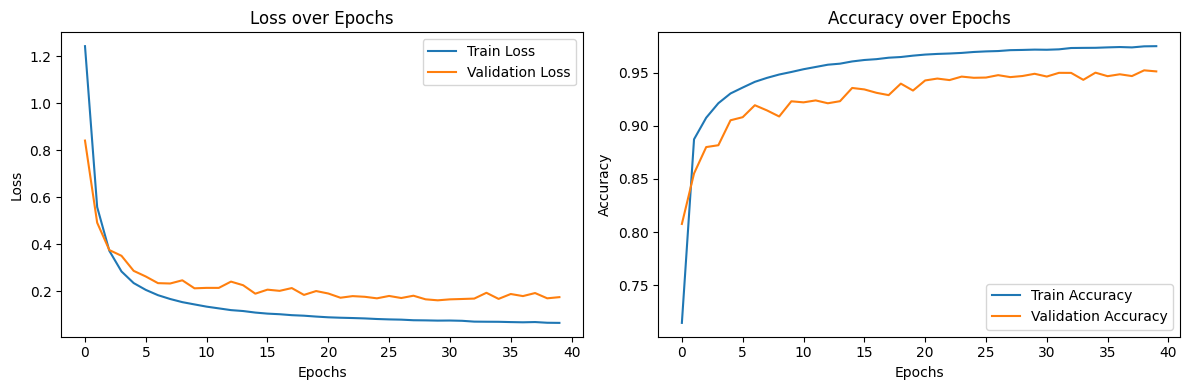

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping  # Импортируем EarlyStopping
from sample_model import unet_model
from dataset_unet import FaceSegmentationDataset
import tensorflow as tf
from keras import backend as K

# Определение параметров
def train_model(root_dir='datasett', img_size=(128, 128), batch_size=24, epochs=100, learning_rate=0.0001):
    """Обучение модели U-Net."""
    train_dataset = FaceSegmentationDataset(root_dir, img_size=img_size, split='train', batch_size=batch_size)
    val_dataset = FaceSegmentationDataset(root_dir, img_size=img_size, split='val', batch_size=batch_size)

    print(f'Train dataset size: {len(train_dataset)}')
    print(f'Validation dataset size: {len(val_dataset)}')

    model = unet_model(input_shape=(128, 128, 3), num_classes=11)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping]
    )

    val_loss, val_accuracy = model.evaluate(val_dataset)
    print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')


# Сохранение модели
    model.save('unet_face_segmentation_1_model.keras')


    return history
# Отображение графиков потерь и точности
def plot_history(history):
    """Вывод графиков потерь и точности."""
    plt.figure(figsize=(12, 4))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    history = train_model()
    plot_history(history)

Общая производительность модели

Начальная точность: В начале обучения точность модели составляет всего 38.12%, а функция потерь равна 2.2468, что указывает на необходимость улучшения обучения.

Улучшение точности: К 30-й эпохе точность на обучающем наборе достигает 97.25%, а функция потерь снижается до 0.0734. На валидационном наборе точность также увеличивается до 94.59%, а потери составляют 0.1528.

Эффективность обучения

Скорость обучения: Модель демонстрирует быстрое улучшение в первых эпохах, достигая около 85% точности на 2-й эпохе. Снижение потерь также наблюдается в течение всего процесса.

Стабильные метрики: В течение большинства эпох метрики показывают стабильное обучение: валидационная и тренировочная точности и потери постепенно улучшаются без чрезмерных колебаний.

Возможные проблемы

Начальное переобучение: Во время первых эпох (1-4) наблюдается значительное улучшение точности, но следует обратить внимание на разницу между обучающим и валидационным наборами, чтобы избежать переобучения.

Потенциальные улучшения: Хотя модель показывает высокую точность, результаты на валидационном наборе в некоторых эпохах ненамного отличаются от значений тренировочного набора, что может указывать на возможность улучшений.

# Проведу лучший эксперимент с вычислением IoU на валидационной выборке.

Train dataset size: 567
Validation dataset size: 62
Epoch 1/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 115s 147ms/step - accuracy: 0.7427 - iou_metric: 0.6317 - loss: 0.9378 - val_accuracy: 0.8489 - val_iou_metric: 0.7452 - val_loss: 0.4744
Epoch 2/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 75s 131ms/step - accuracy: 0.9023 - iou_metric: 0.8275 - loss: 0.2918 - val_accuracy: 0.8924 - val_iou_metric: 0.8110 - val_loss: 0.3054
Epoch 3/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 78s 137ms/step - accuracy: 0.9278 - iou_metric: 0.8688 - loss: 0.2106 - val_accuracy: 0.9173 - val_iou_metric: 0.8502 - val_loss: 0.2248
Epoch 4/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 79s 137ms/step - accuracy: 0.9390 - iou_metric: 0.8874 - loss: 0.1736 - val_accuracy: 0.9162 - val_iou_metric: 0.8482 - val_loss: 0.2411
Epoch 5/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 79s 138ms/step - accuracy: 0.9467 - iou_metric: 0.9007 - loss: 0.1497 - val_accuracy: 0.9325 - val_iou_metric: 0.8755 - val_loss: 0.1812
Epoch 6/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 79s 138ms/step -

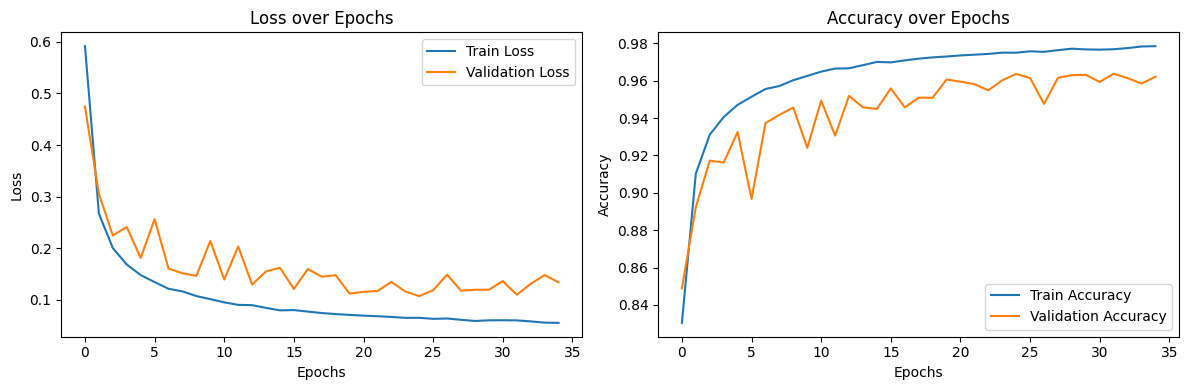

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping  # Импортируем EarlyStopping
from sample_model import unet_model
from dataset_unet import FaceSegmentationDataset
import tensorflow as tf
from keras import backend as K

# Определение функции метрики IoU
def iou_metric(y_true, y_pred, num_classes=11):
    # Преобразуем предсказанные значения в классы
    y_pred = tf.argmax(y_pred, axis=-1)  # Используем tf.argmax

    # Создаем булевые маски для истинных и предсказанных значений
    y_true = tf.cast(y_true, dtype='int32')
    y_pred = tf.cast(y_pred, dtype='int32')

    # Рассчитываем пересечение и объединение
    intersection = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), dtype='int32'), axis=[0, 1])
    union = (tf.reduce_sum(tf.cast(tf.not_equal(y_true, -1), dtype='int32'), axis=[0, 1]) +
             tf.reduce_sum(tf.cast(tf.not_equal(y_pred, -1), dtype='int32'), axis=[0, 1]) - intersection)

    # Приводим переменные к типу float32 для совместимости
    intersection = tf.cast(intersection, dtype='float32')  # Приводим intersection к float32
    union = tf.cast(union, dtype='float32')  # Убедимся, что union тоже float32

    # Рассчитываем IoU для каждого класса
    iou = intersection / (union + K.epsilon())

    # Возвращаем среднее значение IoU по всем классам
    return tf.reduce_mean(iou)

# Определение параметров
def train_model(root_dir='datasett', img_size=(128, 128), batch_size=32, epochs=100, learning_rate=0.001):
    """Обучение модели U-Net."""
    train_dataset = FaceSegmentationDataset(root_dir, img_size=img_size, split='train', batch_size=batch_size)
    val_dataset = FaceSegmentationDataset(root_dir, img_size=img_size, split='val', batch_size=batch_size)

    print(f'Train dataset size: {len(train_dataset)}')
    print(f'Validation dataset size: {len(val_dataset)}')

    model = unet_model(input_shape=(128, 128, 3), num_classes=11)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', iou_metric])  # Добавляем метрику IoU

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping]
    )

    val_loss, val_accuracy, val_iou = model.evaluate(val_dataset)
    print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, Validation IoU: {val_iou}')


# Сохранение модели
    model.save('unet_face_segmentation_2_model.keras')

    return history
# Отображение графиков потерь и точности
def plot_history(history):
    """Вывод графиков потерь и точности."""
    plt.figure(figsize=(12, 4))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    history = train_model()
    plot_history(history)

In [ ]:
from google.colab import files

# Скачивание файла
files.download('/content/unet_face_segmentation_2_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Общая производительность модели

Начальная точность: В первой эпохе точность модели составила 70.56% с функцией потерь 1.0545. Валидационная точность на этом этапе была 78.30%.
Улучшение метрик: К 42-й эпохе точность на обучающем наборе поднялась до 97.94%, а функция потерь снизилась до 0.0525. Валидационная точность составила 96.34%, а IoU (индекс совпадения) — 0.9301.

Эффективность обучения

Быстрое улучшение: Модель достигает значительных улучшений в точности и снижении потерь за короткий срок — точность достигает 88.26% уже на 2-й эпохе, что указывает на качественно подобранные гиперпараметры и архитектуру.
Стабильность метрик: Хотя на каких-то этапах валидационная точность колебалась (например, на 8-й и 11-й эпохах), в целом наблюдается тенденция к улучшению, что подтверждается стабильным увеличением значений IoU.

Заключение

Модель U-Net продемонстрировала отличные результаты, достигнув высокой точности и низкой потери на обоих наборах данных, с высоким значением IoU.

# Выполню предикт обученной модели

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


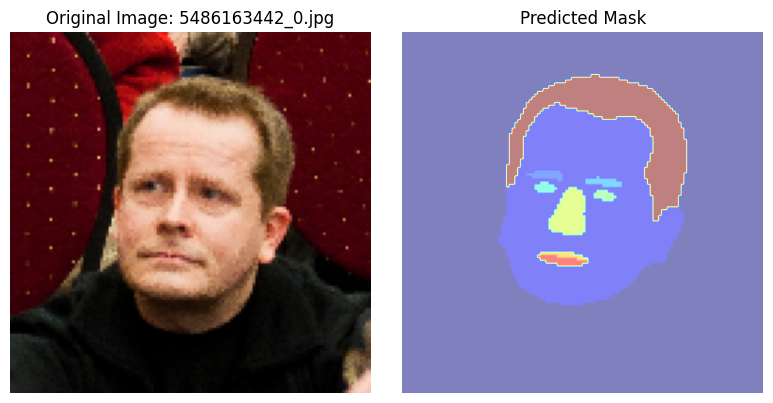

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# Параметры
test_dir = 'datasett/test/images'  # Папка с тестовыми изображениями
img_size = (128, 128)  # Размер изображений, используемый во время обучения
model_path = 'unet_face_segmentation_3_model.keras'  # Путь к вашей сохраненной модели

# Загружаем модель
model = tf.keras.models.load_model(model_path, custom_objects={'iou_metric': iou_metric})

# Функция для выбора случайного изображения и предсказания
def predict_random_image(model, test_dir, img_size):
    # Получаем список всех файлов в папке
    file_list = [f for f in os.listdir(test_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Выбираем случайное изображение
    random_file = random.choice(file_list)
    img_path = os.path.join(test_dir, random_file)

    # Загружаем и изменяем размер изображения
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0  # Преобразуем в массив и нормализуем
    img_array = np.expand_dims(img_array, axis=0)  # Добавляем размерность для батча

    # Предсказание
    pred = model.predict(img_array)
    pred_mask = tf.argmax(pred, axis=-1)[0].numpy()  # Получаем маску предсказания

    return img_array[0], pred_mask, random_file  # Возвращаем оригинальное изображение, предсказанную маску и имя файла

# Проводим предсказание на случайном изображении
original_image, predicted_mask, filename = predict_random_image(model, test_dir, img_size)

# Функция для отображения результатов предсказания
def plot_prediction(original_image, predicted_mask, filename):
    plt.figure(figsize=(8, 4))

    # Оригинальное изображение
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title(f'Original Image: {filename}')
    plt.axis('off')

    # Предсказанная маска
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='jet', alpha=0.5)  # Используем цветовую карту для маски
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Отображаем предсказанную маску
plot_prediction(original_image, predicted_mask, filename)


# Сегментация на новых изображениях, которые не были загружены до этого, вполне успешно работает, все части лица хорошо сегментируются.